In [23]:
import sys
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [24]:
# Constants
data_location = r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\results\2025-08-25"
folders = [name for name in os.listdir(data_location)]
# Go one level deeper and get every pair of (folder, subfolder)
folder_pairs = []
for folder in folders:
    folder_path = os.path.join(data_location, folder)
    if os.path.isdir(folder_path):
        subfolders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
        for subfolder in subfolders:
            folder_pairs.append((folder, subfolder))
print(folder_pairs)

[('orderbooks', 'AAPL'), ('orderbooks', 'BAC'), ('orderbooks', 'GOOG'), ('orderbooks', 'JPM'), ('orderbooks', 'META'), ('orderbooks', 'MSFT'), ('orderbooks', 'MTCH'), ('orderbooks', 'NFLX'), ('orderbooks', 'NVDA'), ('orderbooks', 'ORCL'), ('orderbooks', 'PLTR'), ('orderbooks', 'TSLA'), ('orderfixedvol', 'AAPL'), ('orderfixedvol', 'GOOG'), ('orderfixedvol', 'META'), ('orderfixedvol', 'MSFT'), ('orderfixedvol', 'NFLX'), ('orderfixedvol', 'PLTR'), ('orderfixedvol', 'TSLA'), ('orderflows', 'AAPL'), ('orderflows', 'GOOG'), ('orderflows', 'META'), ('orderflows', 'MSFT'), ('orderflows', 'MTCH'), ('orderflows', 'NFLX'), ('orderflows', 'TSLA'), ('ordervol', 'AAPL'), ('ordervol', 'BAC'), ('ordervol', 'GOOG'), ('ordervol', 'META'), ('ordervol', 'MSFT'), ('ordervol', 'MTCH'), ('ordervol', 'NFLX'), ('ordervol', 'PLTR'), ('ordervol', 'TSLA')]


In [38]:
json_files = [
    {'Representation': representation, 'Ticker': ticker, 'File': f}
    for representation, ticker in folder_pairs
    for f in glob.glob(os.path.join(data_location, representation, ticker, "*.json"))
]

# Load and flatten all JSON files into a single list of records
def flatten_record(entry):
    with open(entry['File'], 'r') as file:
        data = json.load(file)
        records = data if isinstance(data, list) else [data]
        for record in records:
            record.update({'Representation': entry['Representation'], 'Ticker': entry['Ticker']})
            # Flatten nested dicts
            for key in ['meta', 'metrics', 'metricsStrength']:
                if key in record and isinstance(record[key], dict):
                    for k, v in record[key].items():
                        record[f"{key}.{k}"] = v
            yield record

all_data = [rec for entry in json_files for rec in flatten_record(entry)]

joined_df = pd.DataFrame(all_data)
# Reorder columns so that 'Representation' and 'Ticker' are first
cols = ['Representation', 'Ticker'] + [col for col in joined_df.columns if col not in ['Representation', 'Ticker']]
joined_df = joined_df[cols]
data = joined_df.copy()
data

,Representation,Ticker,run_id,datetime,meta,metrics,metricsStrength,meta.model,meta.modelKwargs,meta.numEpoch,...,metricsStrength.accuracy@1%_coverage,metricsStrength.accuracy@5%_coverage,metricsStrength.accuracy@10%_coverage,metricsStrength.accuracy@25%_coverage,metricsStrength.accuracy@50%_coverage,metrics.accuracy,metrics.precision,metrics.recall,metrics.f1,metrics.confusion_matrix
0,orderbooks,AAPL,4Wsd4iYd,2025-08-25 14:15:36,"{'model': 'deepLOBREG_TF', 'modelKwargs': {'sh...","{'MSE': 0.3748973309993744, 'R2': 0.0646546483...","{'accuracy@>0.1': 0.591973452245152, 'coverage...",deepLOBREG_TF,"{'shape': [100, 40, 1]}",10,...,0.730000,0.669867,0.646533,0.620080,0.601920,NaN,NaN,NaN,NaN,NaN
1,orderbooks,AAPL,5e3sUEfh,2025-08-25 14:04:51,"{'model': 'deepLOBREG_TF', 'modelKwargs': {'sh...","{'MSE': 0.30941274762153625, 'R2': 0.067917883...","{'accuracy@>0.1': 0.5410307830008044, 'coverag...",deepLOBREG_TF,"{'shape': [100, 40, 1]}",10,...,0.542000,0.493067,0.495933,0.521733,0.541240,NaN,NaN,NaN,NaN,NaN
2,orderbooks,AAPL,84c0kMhZ,2025-08-25 15:08:47,"{'model': 'deepLOBREG_TF', 'modelKwargs': {'sh...","{'MSE': 0.8273724913597107, 'R2': -0.764856815...","{'accuracy@>0.1': 0.5066348063993892, 'coverag...",deepLOBREG_TF,"{'shape': [100, 40, 1]}",10,...,0.665333,0.521067,0.507867,0.510560,0.512827,NaN,NaN,NaN,NaN,NaN
3,orderbooks,AAPL,aagNnLGZ,2025-08-25 14:47:45,"{'model': 'deepLOBREG_TF', 'modelKwargs': {'sh...","{'MSE': 0.545924186706543, 'R2': -0.1530144214...","{'accuracy@>0.1': 0.4974676371106271, 'coverag...",deepLOBREG_TF,"{'shape': [100, 40, 1]}",10,...,0.446000,0.531333,0.534333,0.508907,0.498080,NaN,NaN,NaN,NaN,NaN
4,orderbooks,AAPL,AncNcPna,2025-08-25 14:55:09,"{'model': 'deepLOB_TF', 'modelKwargs': {'shape...","{'accuracy': 0.3095466666666667, 'precision': ...","{'accuracy@>0.4': 0.3095394496752062, 'coverag...",deepLOB_TF,"{'shape': [100, 40, 1]}",10,...,0.380000,0.356933,0.335800,0.326693,0.320333,0.309547,0.328364,0.330291,0.251791,"[[28260, 210, 15689], [34902, 306, 18886], [33..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,ordervol,TSLA,Lx2oJFwW,2025-08-25 16:18:39,"{'model': 'deepLOB_TF', 'modelKwargs': {'shape...","{'accuracy': 0.48321386897816304, 'precision':...","{'accuracy@>0.4': 0.4923873976929719, 'coverag...",deepLOB_TF,"{'shape': [100, 20, 1]}",10,...,0.690460,0.617231,0.587584,0.555757,0.524811,0.483214,0.478590,0.467670,0.471582,"[[18130, 18940, 4717], [16260, 37474, 13471], ..."
337,ordervol,TSLA,PCGcFL6w,2025-08-25 16:52:12,"{'model': 'deepLOB_TF', 'modelKwargs': {'shape...","{'accuracy': 0.4977761477678125, 'precision': ...","{'accuracy@>0.4': 0.5056557714415476, 'coverag...",deepLOB_TF,"{'shape': [100, 20, 1]}",10,...,0.708472,0.680181,0.659443,0.617215,0.570164,0.497776,0.331881,0.447585,0.381103,"[[38575, 0, 17826], [20428, 0, 18380], [18682,..."
338,ordervol,TSLA,quRpKN1N,2025-08-25 18:01:19,"{'model': 'deepLOB_TF', 'modelKwargs': {'shape...","{'accuracy': 0.3788666155231647, 'precision': ...","{'accuracy@>0.4': 0.39620557921126986, 'covera...",deepLOB_TF,"{'shape': [100, 20, 1]}",10,...,0.558372,0.482188,0.446898,0.431690,0.410930,0.378867,0.376831,0.395050,0.331506,"[[29336, 1888, 14940], [28811, 2698, 22703], [..."
339,ordervol,TSLA,t2Oeaoiv,2025-08-25 18:21:32,"{'model': 'deepLOB_TF', 'modelKwargs': {'shape...","{'accuracy': 0.37104446742502584, 'precision':...","{'accuracy@>0.4': 0.3845522171770843, 'coverag...",deepLOB_TF,"{'shape': [100, 20, 1]}",10,...,0.387850,0.418868,0.416600,0.410451,0.393438,0.371044,0.364611,0.375568,0.316004,"[[29829, 1340, 19396], [26284, 1868, 23386], [..."


In [28]:
print(data.columns)

Index(['Representation', 'Ticker', 'run_id', 'datetime', 'meta', 'metrics',
       'metricsStrength', 'meta.model', 'meta.modelKwargs', 'meta.numEpoch',
       'meta.batchSize', 'meta.ticker', 'meta.steps', 'meta.maxFiles',
       'meta.scaling', 'meta.threshold', 'meta.rowLim', 'meta.trainTestSplit',
       'meta.lookForwardHorizon', 'meta.representation', 'meta.labelType',
       'meta.archive', 'metrics.MSE', 'metrics.R2', 'metrics.MAPE',
       'metrics.MAE', 'metricsStrength.accuracy@>0.1',
       'metricsStrength.coverage@>0.1', 'metricsStrength.accuracy@>0.2',
       'metricsStrength.coverage@>0.2', 'metricsStrength.accuracy@>0.3',
       'metricsStrength.coverage@>0.3', 'metricsStrength.accuracy@>0.4',
       'metricsStrength.coverage@>0.4', 'metricsStrength.accuracy@>0.5',
       'metricsStrength.coverage@>0.5', 'metricsStrength.accuracy@>0.6',
       'metricsStrength.coverage@>0.6', 'metricsStrength.accuracy@>0.7',
       'metricsStrength.coverage@>0.7', 'metricsStrength.accu

In [37]:
data.groupby(['Representation', 'Ticker', 'meta.labelType'])['meta.lookForwardHorizon'].agg(lambda x: ','.join(map(str, x)))

Representation  Ticker  meta.labelType
orderbooks      AAPL    CATEGORICAL       100,80,60,10,40,200,20
                        REGRESSION        20,10,200,80,40,100,60
                BAC     CATEGORICAL       60,100,80,200,20,10,40
                        REGRESSION        100,20,200,80,10,60,40
                GOOG    CATEGORICAL       40,60,80,20,200,10,100
                        REGRESSION        60,40,80,100,20,10,200
                JPM     CATEGORICAL       100,40,60,10,20,80,200
                META    CATEGORICAL                        20,10
                        REGRESSION        100,20,200,60,10,80,40
                MSFT    CATEGORICAL       10,100,200,20,40,80,60
                        REGRESSION        200,10,40,80,20,60,100
                MTCH    CATEGORICAL       100,10,80,200,40,20,60
                        REGRESSION        10,20,40,200,100,80,60
                NFLX    CATEGORICAL       60,10,200,40,20,80,100
                        REGRESSION        40,10,200

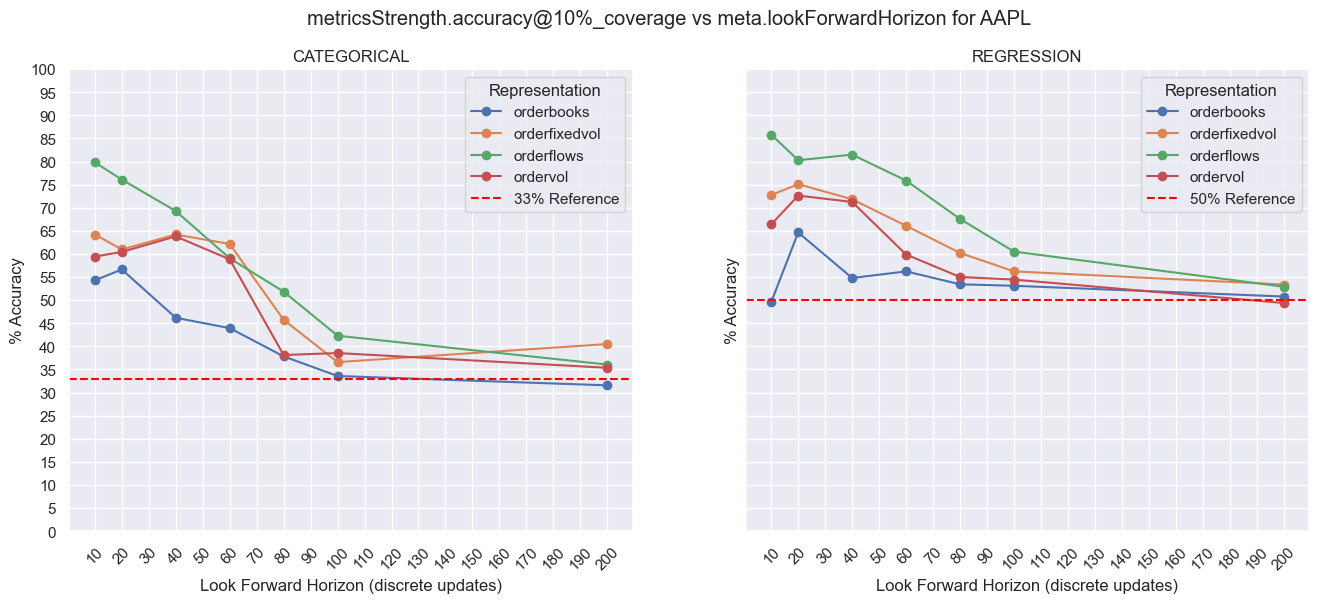

In [143]:
# Plotting
ticker = 'AAPL'
labelType = 'REGRESSION'
y_axis_col = 'metricsStrength.accuracy@10%_coverage'
x_axis_col = 'meta.lookForwardHorizon'

filtered = data.loc[
    (data['meta.ticker'] == ticker) &
    (data['meta.labelType'] == labelType)
]

df = filtered[['Ticker', 'meta.representation', x_axis_col, y_axis_col]]
df

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, label_type in zip(axes, ['CATEGORICAL', 'REGRESSION']):
    filtered = data.loc[
        (data['meta.ticker'] == ticker) &
        (data['meta.labelType'] == label_type)
    ]
    df = filtered[['Ticker', 'meta.representation', x_axis_col, y_axis_col]]
    for rep in df['meta.representation'].unique():
        subset = df[df['meta.representation'] == rep].sort_values(by=x_axis_col)
        ax.plot(subset[x_axis_col], subset[y_axis_col] * 100, marker='o', label=rep)
    ax.set_xlabel("Look Forward Horizon (discrete updates)")
    ax.set_title(f"{label_type}")
    ax.grid(True)
    axHeight = 33 if label_type == 'CATEGORICAL' else 50
    ax.axhline(axHeight, color='red', linestyle='--', label=f'{int(axHeight)}% Reference')
    ax.legend(title="Representation")
    ax.set_ylabel("% Accuracy")
    ax.set_yticks(np.arange(0, 1.05, 0.05) * 100)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xticks(np.arange(10, 210, 10))

fig.suptitle(f"{y_axis_col} vs {x_axis_col} for {ticker}")

plt.show()

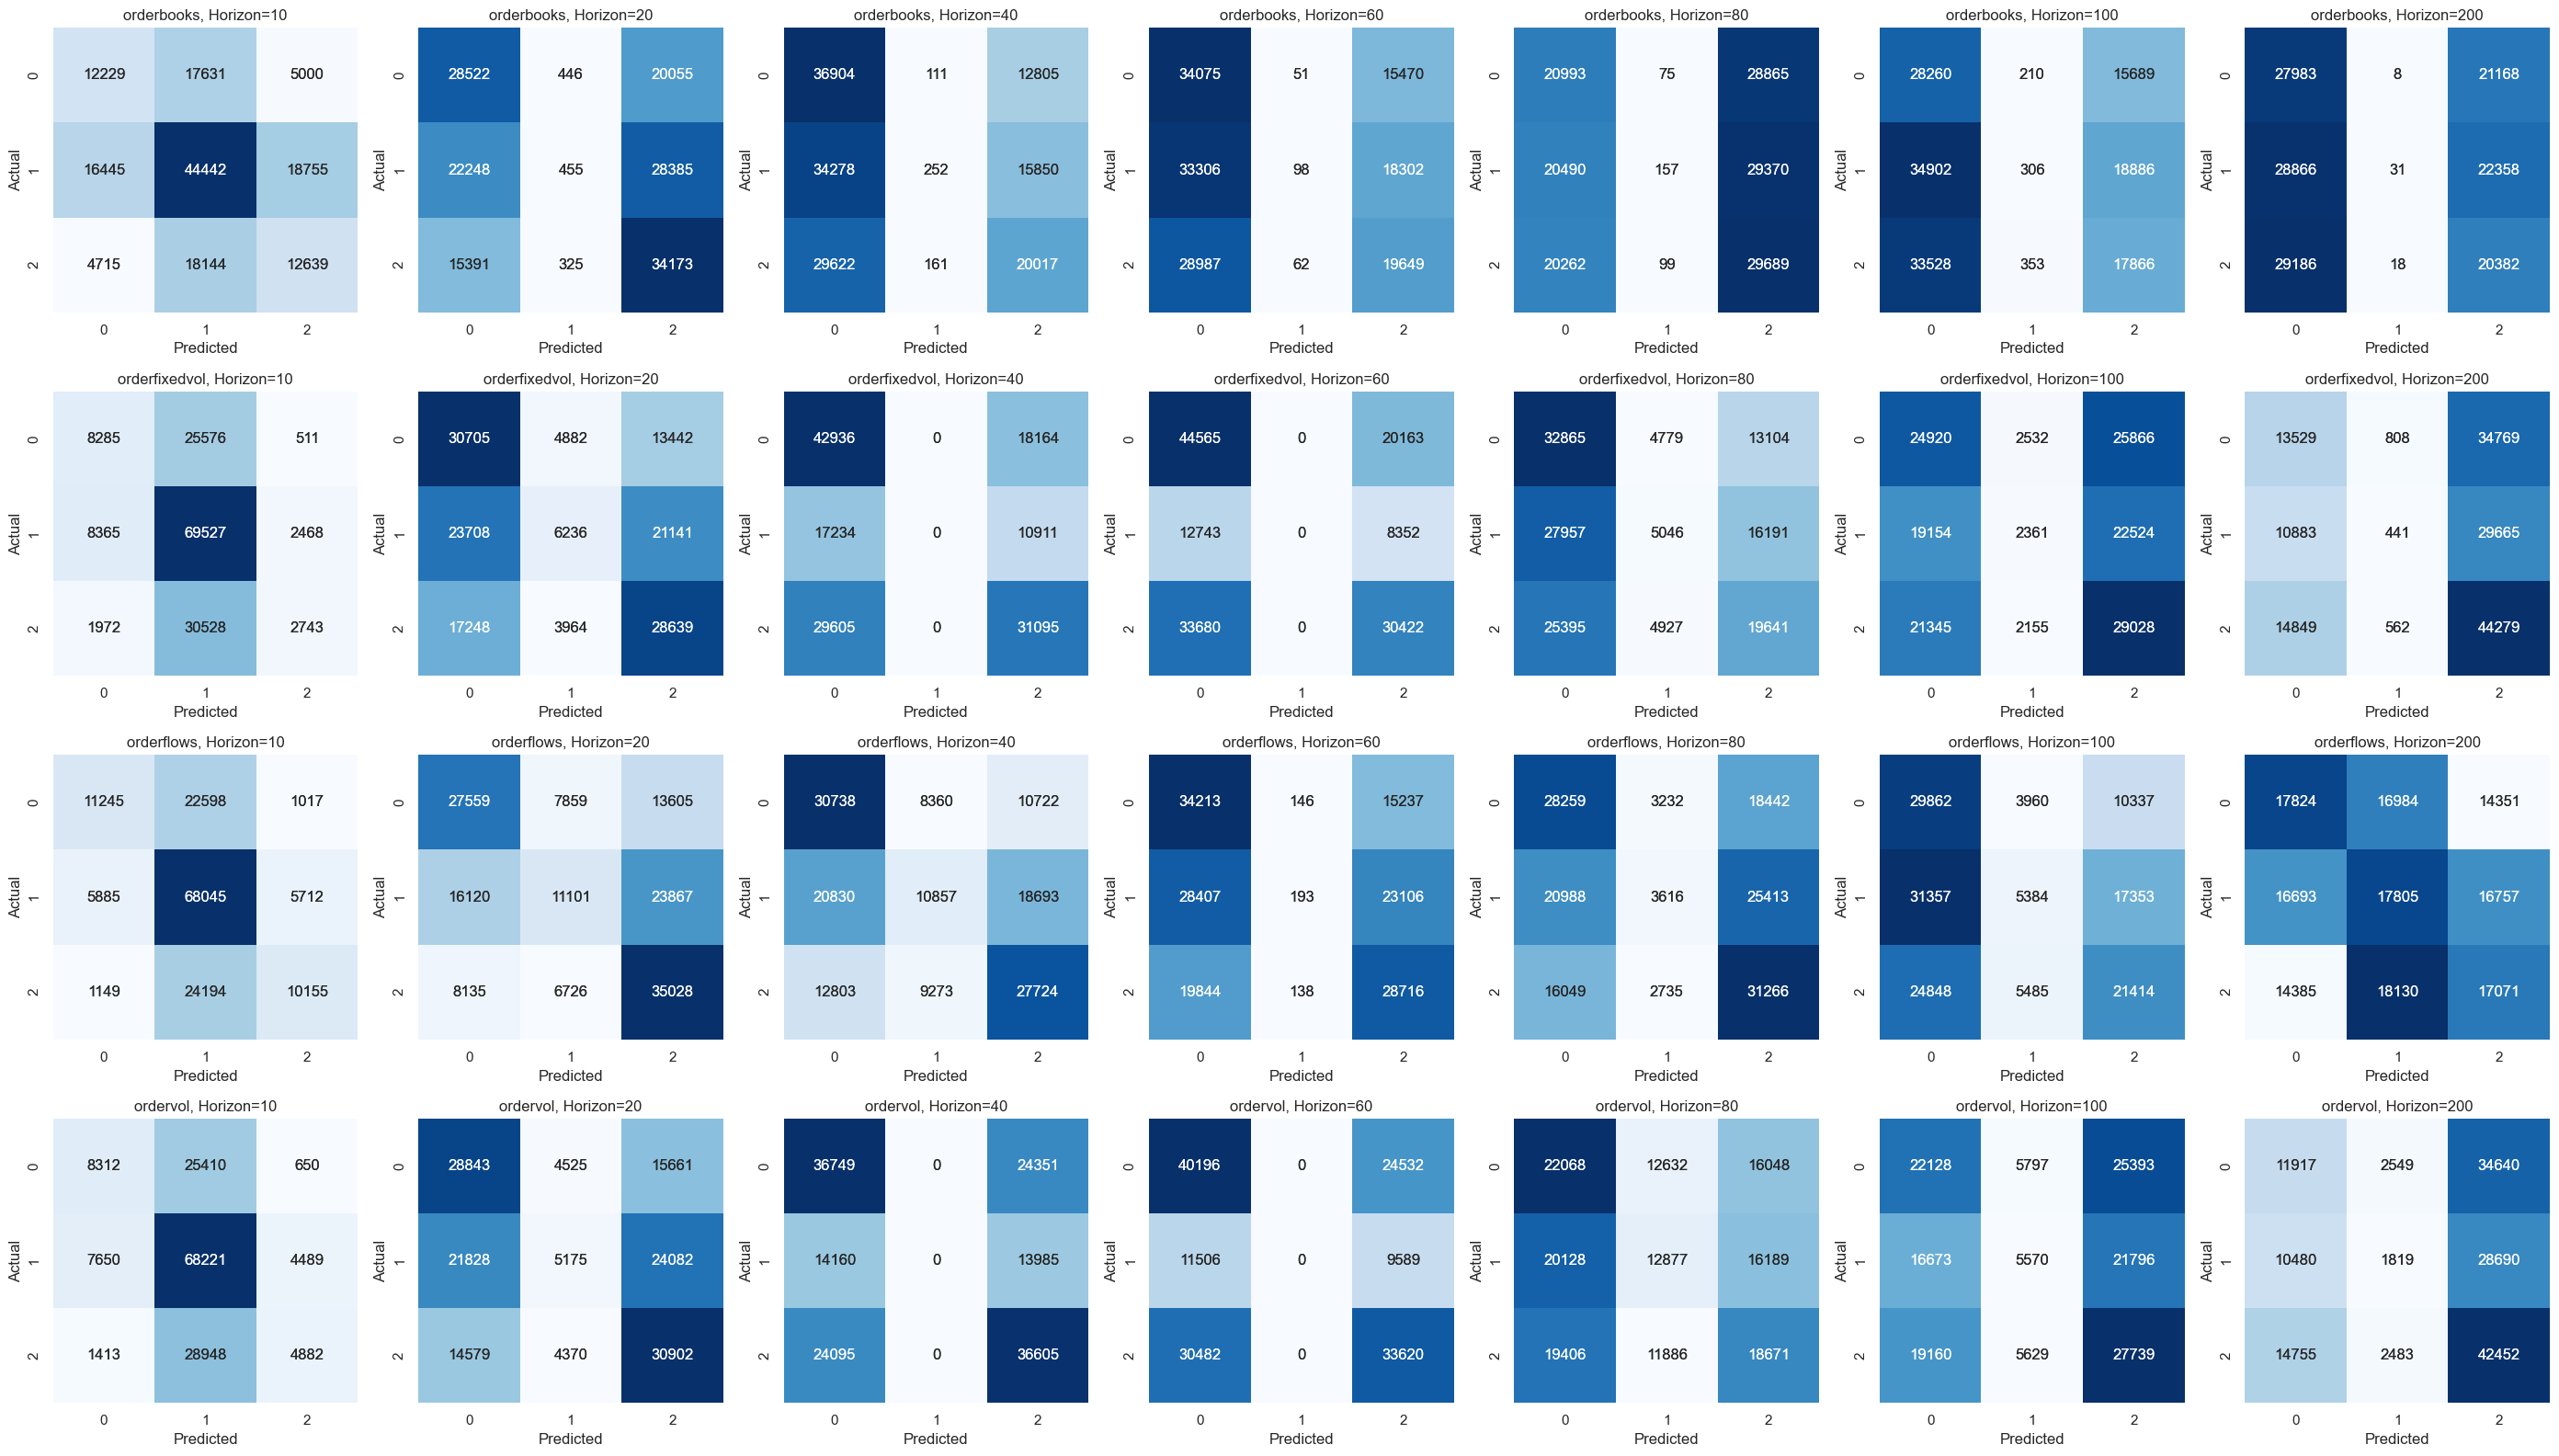

In [87]:
# Plotting
ticker = 'AAPL'
labelType = 'CATEGORICAL'
y_axis_col = 'metricsStrength.accuracy@1%_coverage'
x_axis_col = 'meta.lookForwardHorizon'

filtered = data.loc[
    (data['meta.ticker'] == ticker) &
    (data['meta.labelType'] == labelType)
]

df = filtered[['Ticker', 'meta.representation', 'meta.lookForwardHorizon', 'metrics.confusion_matrix', ]]
# Show the dataframe
df

# Pivot the dataframe so that each row is a unique representation and each column is a lookForwardHorizon
pivot_df = df.pivot(index='meta.representation', columns='meta.lookForwardHorizon', values='metrics.confusion_matrix')

# Plot heatmaps for each cell in the pivot table
fig, axes = plt.subplots(nrows=pivot_df.shape[0], ncols=pivot_df.shape[1], figsize=(4 * pivot_df.shape[1], 4 * pivot_df.shape[0]))

for i, rep in enumerate(pivot_df.index):
    for j, horizon in enumerate(pivot_df.columns):
        cm = pivot_df.loc[rep, horizon]
        ax = axes[i, j] if pivot_df.shape[0] > 1 and pivot_df.shape[1] > 1 else axes[max(i, j)]
        sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        if isinstance(cm, list):
            sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f"{rep}, Horizon={horizon}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        else:
            ax.axis('off')
plt.tight_layout()
plt.show()

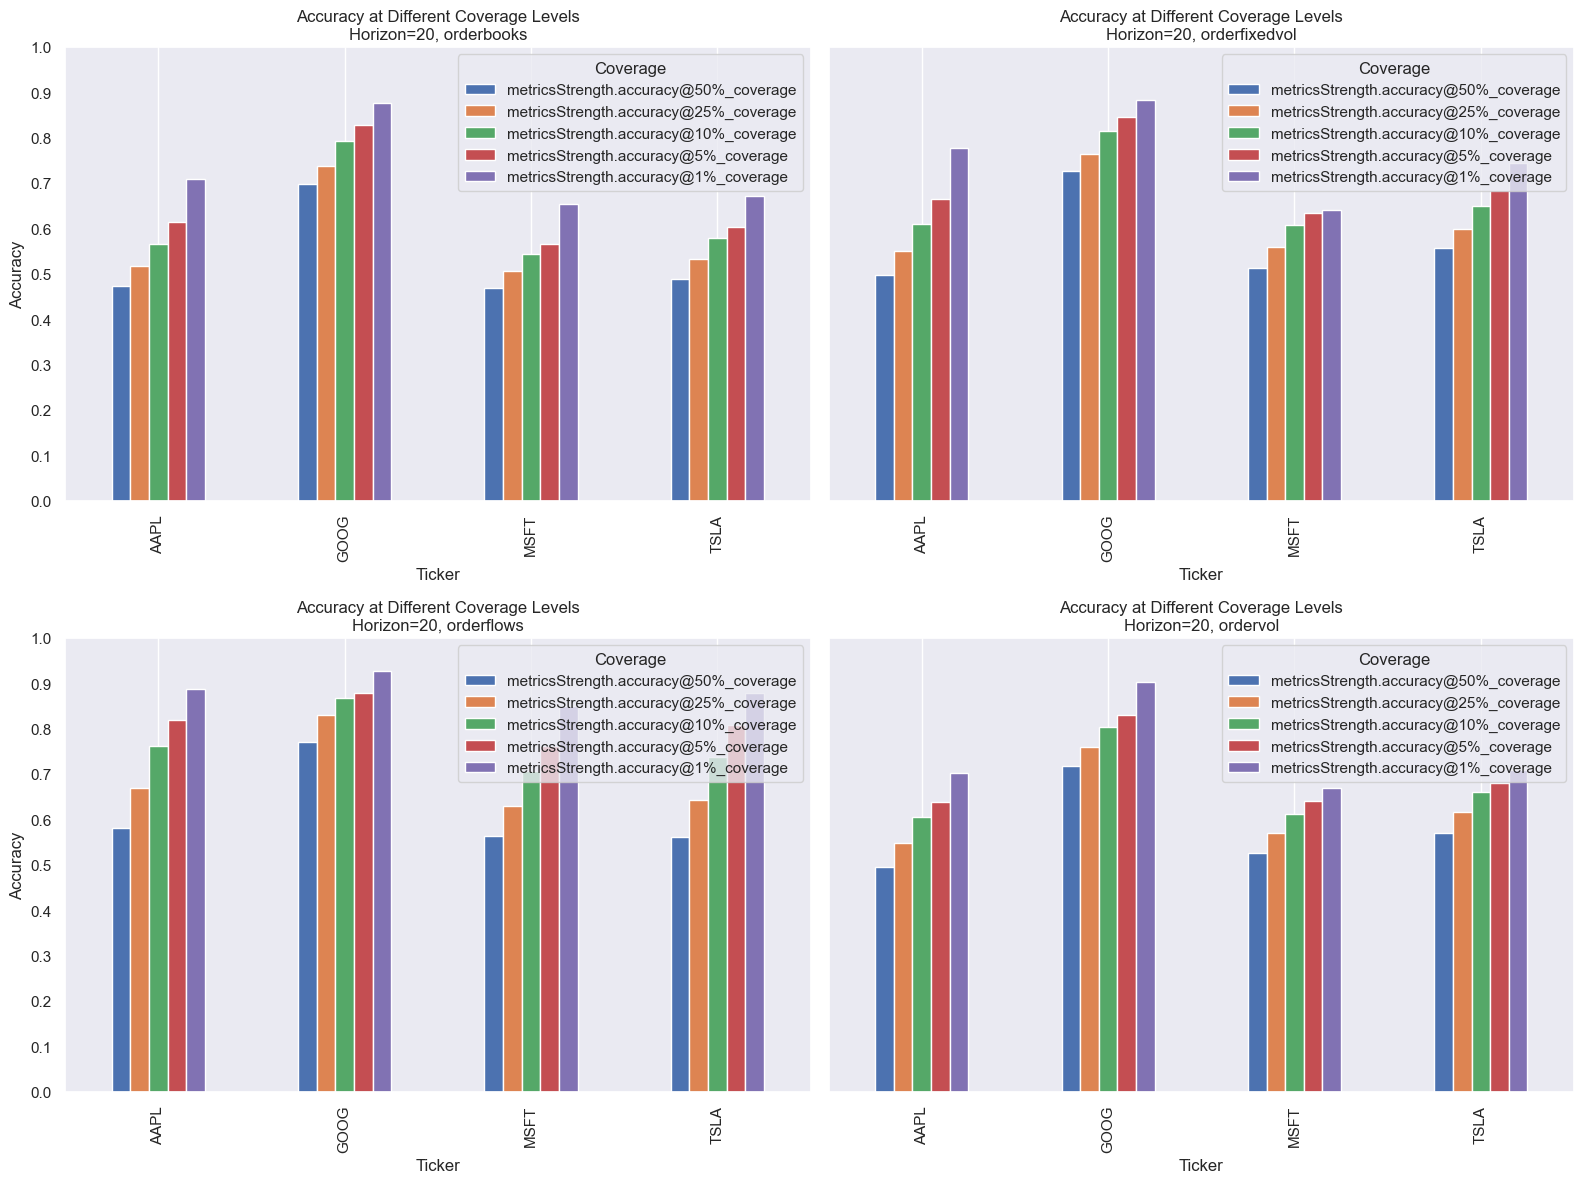

In [156]:
# Plot accuracy at different coverage levels for four representations in a 2x2 grid

representations = ['orderbooks', 'orderfixedvol', 'orderflows', 'ordervol']

tickers = ['AAPL', 'GOOG', 'MSFT', 'TSLA']

percentages = [50, 25, 10, 5, 1]

accuracy_cols = [
    f'metricsStrength.accuracy@{pcnt}%_coverage' for pcnt in percentages
]
fixed_horizon = 20

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)


for ax, rep in zip(axes.flat, representations):
    df_bar = data.loc[
        (data['meta.representation'] == rep) &
        (data['meta.lookForwardHorizon'] == fixed_horizon) &
        (data['meta.labelType'] == labelType) &
        (data['Ticker'].isin(tickers))
    ]
    plot_df = df_bar[['Ticker'] + accuracy_cols].set_index('Ticker')
    plot_df.plot(kind='bar', ax=ax)
    ax.set_title(f'Accuracy at Different Coverage Levels\nHorizon={fixed_horizon}, {rep}')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Ticker')
    ax.legend(title='Coverage Level')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.grid(axis='y')
    ax.legend(title='Coverage')

plt.tight_layout()
plt.show()


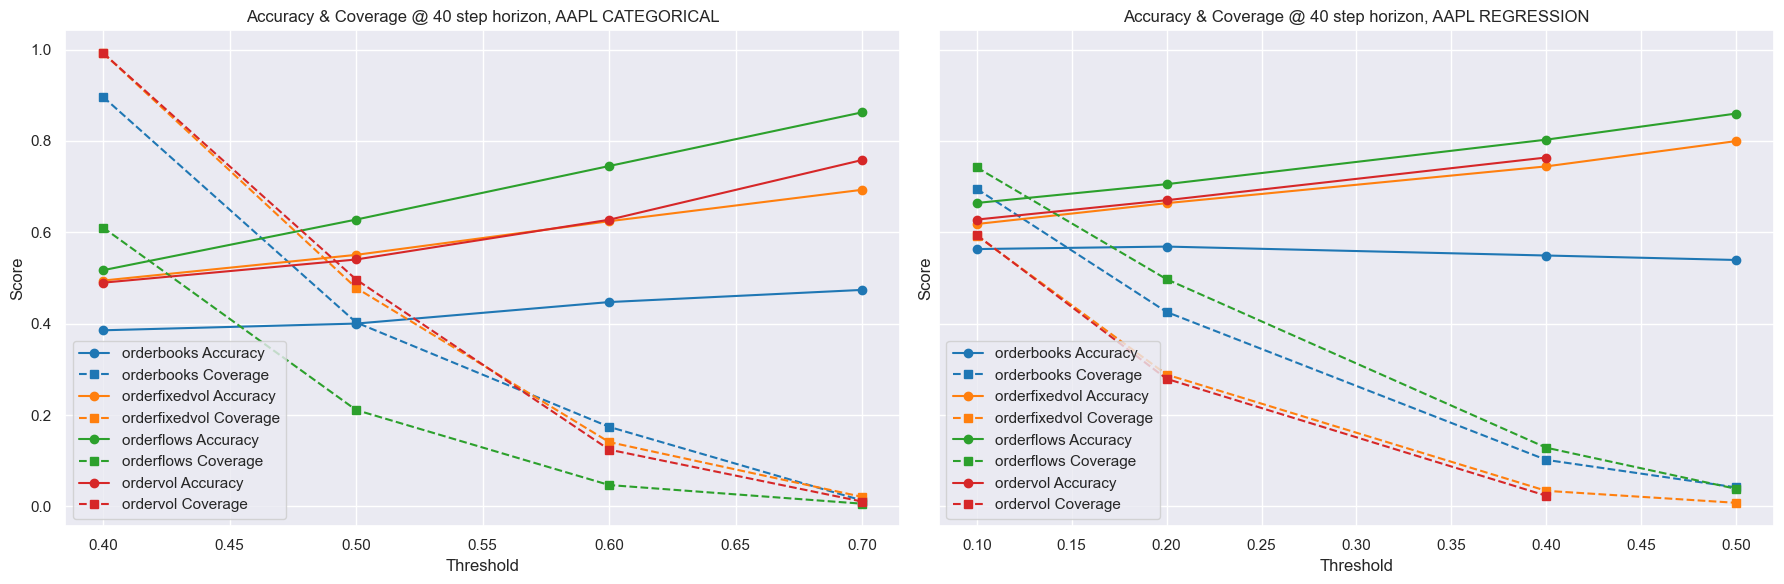

In [183]:
# Plot accuracy and coverage for each representation for AAPL at horizon=20, both CATEGORICAL and REGRESSION

horizon = 40
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
thresholds_all  = [.1*i for i in range(10)]
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
colors = plt.cm.tab10.colors

coverage_lim = 0.005

for ax, labelType in zip(axes, ['CATEGORICAL', 'REGRESSION']):
    for idx, rep in enumerate(representations):
        subset = data[
            (data['meta.ticker'] == 'AAPL') &
            (data['meta.labelType'] == labelType) &
            (data['meta.lookForwardHorizon'] == horizon) &
            (data['meta.representation'] == rep)
        ]
        acc_y, cov_y, x_vals = [], [], []
        threshes = thresholds if labelType == 'CATEGORICAL' else thresholds_all
        for thresh in threshes:
            acc_col = f'metricsStrength.accuracy@>{thresh}'
            cov_col = f'metricsStrength.coverage@>{thresh}'
            if acc_col in subset.columns and cov_col in subset.columns and not subset.empty and subset.iloc[0][cov_col] > coverage_lim:
                acc_val = subset.iloc[0][acc_col]
                cov_val = subset.iloc[0][cov_col]
                if not pd.isna(acc_val) and not pd.isna(cov_val):
                    x_vals.append(thresh)
                    acc_y.append(acc_val)
                    cov_y.append(cov_val)
        color = colors[idx % len(colors)]
        ax.plot(x_vals, acc_y, marker='o', label=f'{rep} Accuracy', color=color)
        ax.plot(x_vals, cov_y, marker='s', label=f'{rep} Coverage', color=color, linestyle='--')
    ax.set_title(f'Accuracy & Coverage @ {horizon} step horizon, AAPL {labelType}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


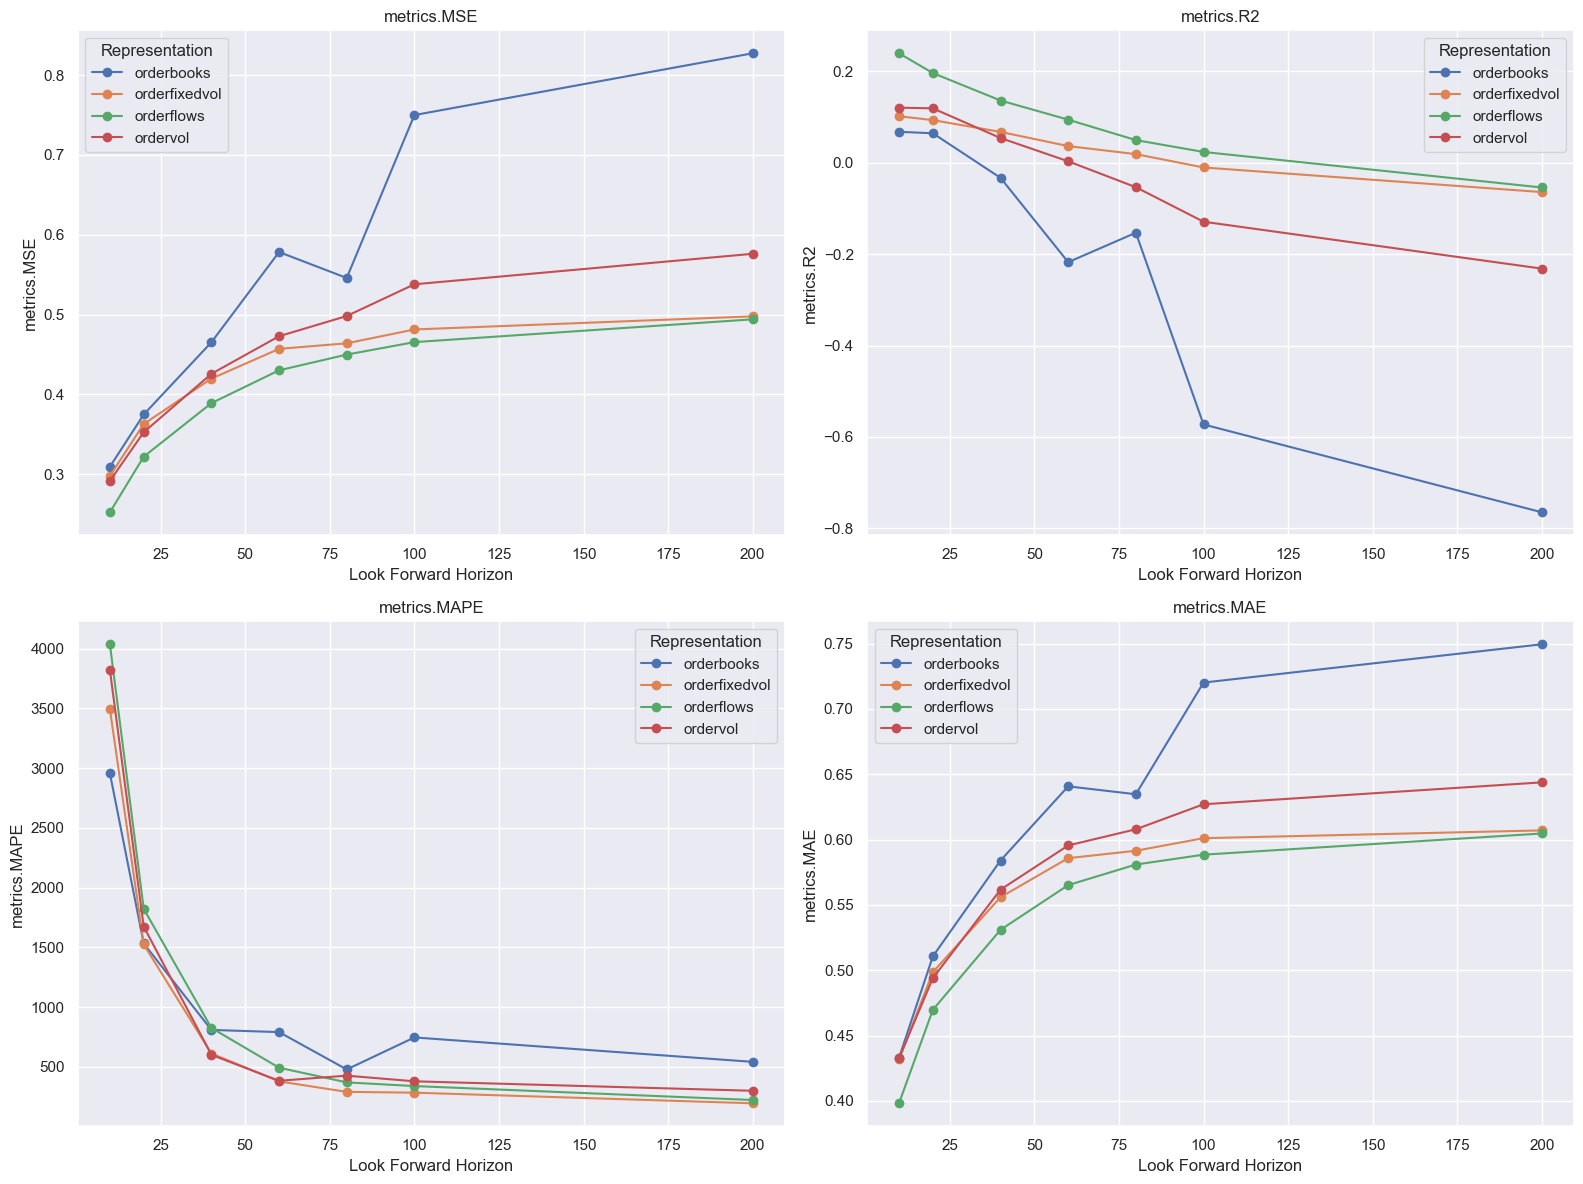

In [ ]:
# Plot metrics for REGRESSION format: 'metrics.MSE', 'metrics.R2', 'metrics.MAPE', 'metrics.MAE'
ticker = 'AAPL'
metrics_to_plot = ['metrics.MSE', 'metrics.R2', 'metrics.MAPE', 'metrics.MAE']

regression_df = data[
    (data['meta.labelType'] == 'REGRESSION') &
    (data['Ticker'] == ticker)
].sort_values('meta.lookForwardHorizon')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):
    for rep in regression_df['meta.representation'].unique():
        subset = regression_df[regression_df['meta.representation'] == rep]
        ax.plot(
            subset['meta.lookForwardHorizon'],
            subset[metric],
            marker='o',
            label=rep
        )
    ax.set_title(metric)
    ax.set_xlabel('Look Forward Horizon')
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(title='Representation')

plt.tight_layout()
plt.show()

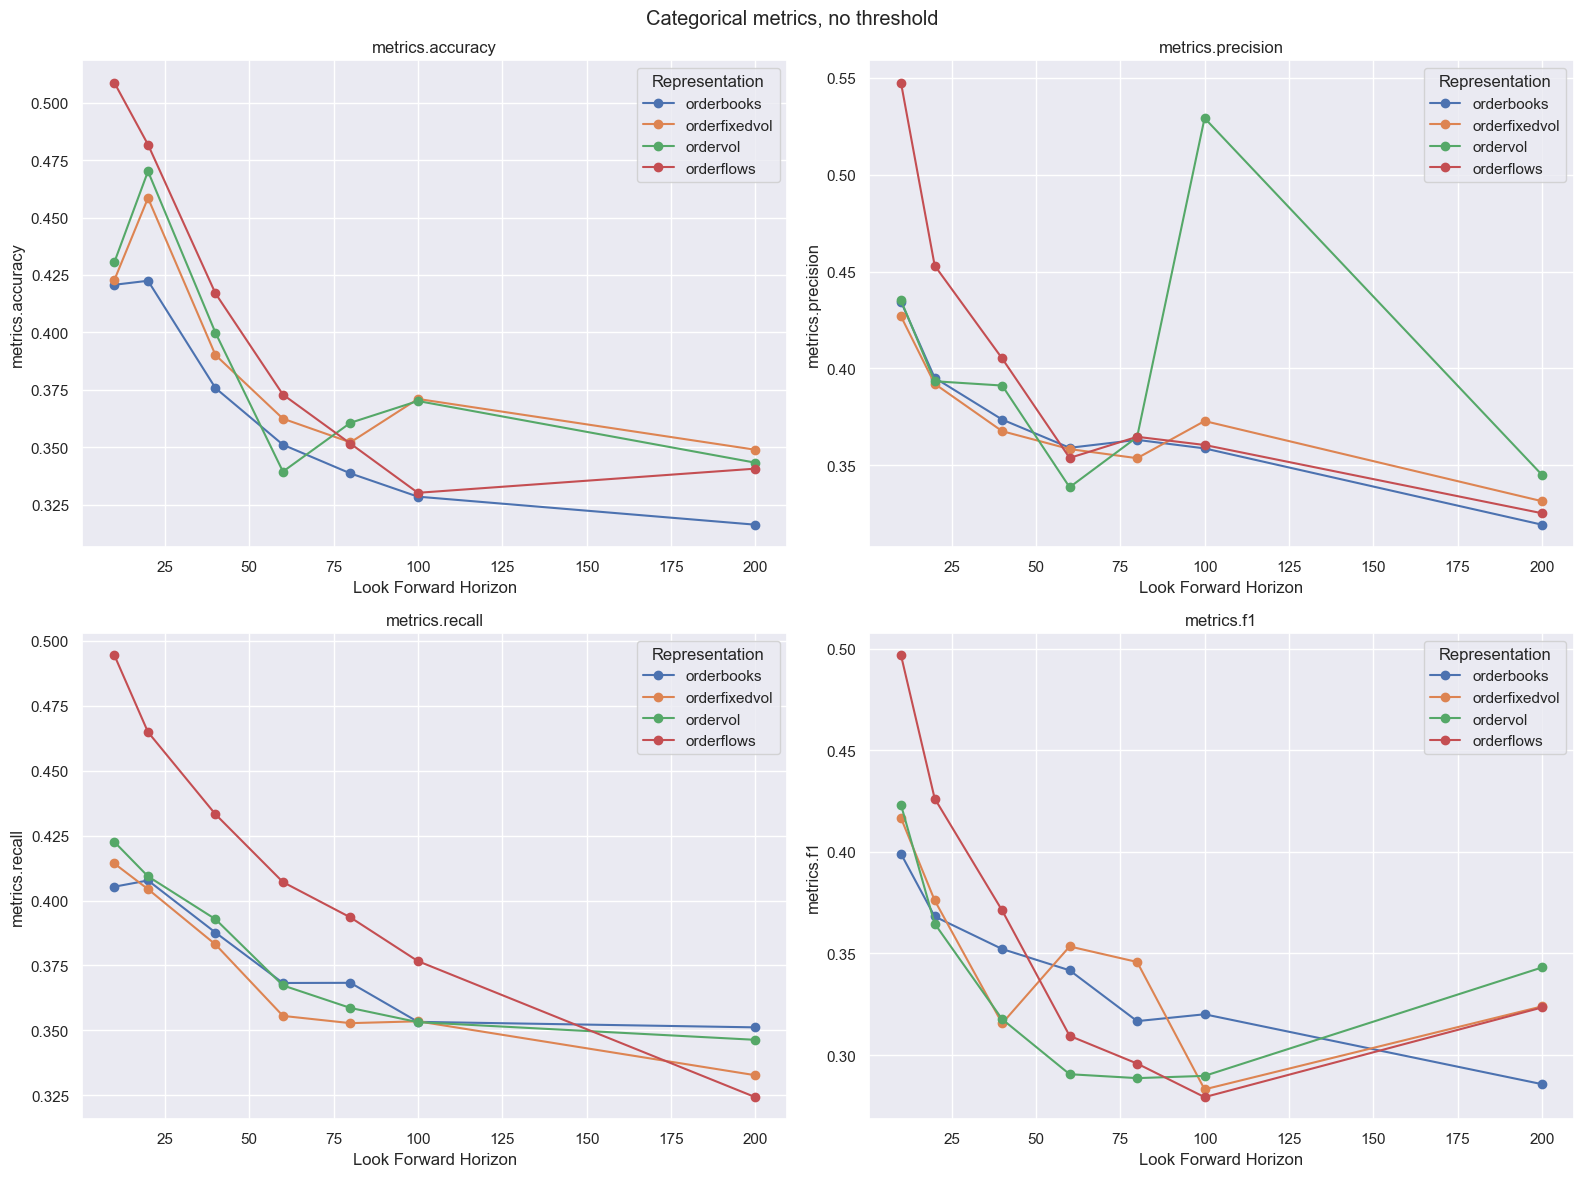

In [197]:
# Plot metrics for CATEGORICAL format: 'metrics.accuracy', 'metrics.precision', 'metrics.recall', 'metrics.f1'
ticker = 'MSFT'

metrics_to_plot = ['metrics.accuracy', 'metrics.precision', 'metrics.recall', 'metrics.f1']

categorical_df = data[
    (data['meta.labelType'] == 'CATEGORICAL') &
    (data['Ticker'] == ticker)
].sort_values(x_axis_col)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):
    for rep in categorical_df['meta.representation'].unique():
        subset = categorical_df[categorical_df['meta.representation'] == rep]
        ax.plot(
            subset[x_axis_col],
            subset[metric],
            marker='o',
            label=rep
        )
    ax.set_title(metric)
    ax.set_xlabel('Look Forward Horizon')
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(title='Representation')

fig.suptitle("Categorical metrics, no threshold")

plt.tight_layout()
plt.show()